In [69]:
#####################################################################
# This notebook is authored by: Ayan Paul                           #
# Date: November 2020                                               #
# If you use this code or the results from this work please cite:   # 
# Resurrecting bbh with kinematic shapes                            #
# Christophe Grojean, Ayan Paul and Zuoni Qian                      #
# arXiv:2011.13945 (https://arxiv.org/abs/2011.13945)               # 
#####################################################################

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math as m
import collections
import pickle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from colour import Color
from matplotlib import rc
import sys


# To supress warnings from shap
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
N_THREADS = 88 ## Change for reducing load on CPU
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)
seed = 42

colors = ['#3f7f93','#da3b46']
cmp_2 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#3f7f93','#da3b46','#98b83b']
cmp_3 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#3f7f93','#da3b46','#F6AE2D', '#98b83b']
cmp_4 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#3f7f93','#da3b46','#F6AE2D', '#98b83b', '#825FC3']
cmp_5 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

## Helper funtion for I/O, BDT analysis and evaluation of results

In [66]:
def fileparser(path, dlist, frac=0.5, sample=0, L=2, weights=True):
    """ The fileparser to read the events from a csv
        argument:
            path: the path to the file
            dlist: the list of variables to be excluded
            frac: the fraction of sample that will be the test sample when sample is set to 0
            sample: the number of events that will be the train sample.
            L: Luminosity scaling
        returns:
            df_train: the training dataframe
            df_test: the testing dataframe
            weight: the weight (related to crosssection)
    """
    df = pd.read_csv(path)
    df.drop(columns=dlist, inplace=True)    
    n = len(df)
    if weights: weight = int(round(np.abs(df['weight'].sum()) * 3. * 1e6 * L)) ## The abs(mean()) is taken to make the weight of ybyt +ve
    else: weight = int(round(np.abs(df['weight'].mean()) * 3. * 1e3 * L)) ## REMEMBER: Weight is put by hand in the root file and is just the XS in fb.
#     df['weight'] = df['weight']/np.abs(df['weight'])
    if sample != 0:
        df_train = df.sample(n=sample, random_state=seed)
        df_test = df.drop(df_train.index)
    else :
        df_test = df.sample(frac=frac, random_state=seed)
        df_train = df.drop(df_test.index)
#     df_train = df_train[(df_train.maa > 123) & (df_train.maa < 127)]
#     df_test = df_test[(df_test.maa > 123) & (df_test.maa < 127)]
    return df_train, df_test, weight

def runBDT(df, filename='', rf=False, depth=10, sample=1, seed=seed):
    """ The BDT/RF runner
        argument:
            df: the dataframe with all the events
            filename: the name of the pickle file to store the model in
            rf: a bolean to toggle between BDT and Random Forest classifiers
            sample: The fraction of variables to sample
            seed: the seed for the random number generator
        returns:
            classifier: the classifier
            x_test: the features for the test set
            y_test: the labels for the test set
            shap_values: the SHAP values
            X_shap: the feature set with which the shap values have been computed
    """
    mshap = True if depth <= 10 else False
    df = df.sample(frac=sample)
    X = df.drop(columns=['class', 'weight'])
    y = df['class'].values

    # Split for training and testing
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2, random_state=seed)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    
    # Fit the decision tree
    if rf: 
        classifier = ensemble.RandomForestClassifier(max_depth=depth, n_estimators=1000, criterion='gini', n_jobs=int(N_THREADS/2), random_state=seed)
        classifier = classifier.fit(x_train, y_train)
    else: 
        classifier = xgb.XGBClassifier(max_depth=depth, learning_rate=0.01, objective='multi:softprob', num_class=nchannels,
                                         nthread=N_THREADS, subsample=0.5, colsample_bytree=1, n_estimators=5000, random_state=seed)
        classifier = classifier.fit(x_train, y_train, early_stopping_rounds=50, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    # Predictions
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    if filename != '': pickle.dump(classifier, open(filename, 'wb'))
    
    # Calculate the SHAP scores
    if mshap:
        X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class', 'weight']).columns)
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_shap)
    else:
        shap_values = []
        X_shap = pd.DataFrame()
        
    return classifier, x_test, y_test, shap_values, X_shap

def eval_training(classifier):
    """ Evaluate the training
        argument:
            classifier: the BDT classifier
    """
    results = classifier.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)

    # plot log loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='test')
    plt.legend()

    plt.ylabel('log loss')
    plt.title('Classifier log loss')
    plt.grid()

    # plot classification error
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, results['validation_0']['merror'], label='train')
    plt.plot(x_axis, results['validation_1']['merror'], label='test')
    plt.legend()

    plt.ylabel('Classification Error')
    plt.title('Classification Error')
    plt.grid()
    plt.show()
    
def get_mclass(i, df_array, weight_array, ps_exp_class, seed=seed):
    """ This function is used to create the confusion matrix
        arguments:
            i: integer corresponding to the class number
            df_array: the array of the dataframes of the different classes
            weight_array: the array of the weights for the different classes
            ps_exp_class: the collection of the pseudo experiment events
            seed: the seed for the random number generator
        returns:
            nevents: the number of events
            sif: the significance
    """
    mclass = []
    for j in range(nchannels):
        mclass.append(collections.Counter(classifier.predict(df_array[j].iloc[:,:-2].values))[i]/len(df_array[j])*weight_array[j]/weight_array[i])

    sig = np.sqrt(ps_exp_class[i])*mclass[i]/np.sum(mclass)
    nevents = np.round(ps_exp_class[i]/np.sum(mclass)*np.array(mclass)).astype(int)
    if nchannels == 5: print('sig: {:2.2f}, ku events: {}, hhsm events: {}, tth events: {}, bbh events: {}, bbxaa events: {}'.format(sig, nevents[4], nevents[3], nevents[2], nevents[1], nevents[0]))
    if nchannels == 4: print('sig: {:2.2f}, hhsm events: {}, tth events: {}, bbh events: {}, bbxaa events: {}'.format(sig, nevents[3], nevents[2], nevents[1], nevents[0]))
    if nchannels == 2: print('sig: {:2.2f}, ku events: {}, hhsm events: {}'.format(sig, nevents[1], nevents[0]))
    return nevents, sig 


def abs_shap(df_shap, df, shap_plot, names, class_names, cmp):
    ''' A function to plot the bar plot for the mean abs SHAP values
        arguments:
            df_shap: the dataframe of the SHAP values
            df: the dataframe for the feature values for which the SHAP values have been determined
            shap_plot: The name of the output file for the plot
            names: The names of the variables
            class_names: names of the classes
            cmp: the colour map
    '''
    rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
    plt.figure(figsize=(5,5))
    shap.summary_plot(df_shap, df, color=cmp, class_names=class_names, class_inds='original', plot_size=(5,5), show=False)#, feature_names=names)
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right', fontsize=15)
    plt.xlabel(r'$\overline{|S_v|}$', fontsize=15)
    ax = plt.gca()
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    vals = ax.get_xticks()
    ax.tick_params(axis='both', which='major', labelsize=15)
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.7, color='#808080', zorder=0, linewidth=0.5)
    plt.tight_layout()
    plt.savefig(shap_plot, dpi=300)
    rc('text', usetex=False)
    
#define a function to convert logodds to probability for multi-class 
def logodds_to_proba(logodds):
    return np.exp(logodds)/np.exp(logodds).sum()

## 14 TeV Analysis

### Load the data

In [103]:
# dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']
# dlist = ['etaaa', 'ptb2', 'drbamin', 'etaa2', 'etab1', 'etaa1', 'mbbh', 'met', 'drbamin', 'njjet', 'etab2']
# dlist = ['ptb2', 'etaaa', 'etaa1', 'met', 'pta1', 'etab1', 'etaa2', 'dphibb', 'dphiba1', 'etab2']
# dlist = ['ptb2', 'etab2', 'nbjet', 'etaaa', 'dphibb', 'drba1', 'etaa1', 'etab1']
# dlist = ['ptb2', 'etab2', 'nbjet', 'etaaa', 'dphibb', 'drba1', 'etaa1', 'etab1', 'dphiba1', 'etaa2', 'mb1h', 'mbbh', 'drbamin', 'pta2']
dlist = ['ptb2', 'etab2', 'nbjet', 'etaaa', 'dphibb', 'drba1', 'etaa1', 'etab1', 'dphiba1', 'drbamin', 'pta2']
# names = [r'$n_{jet}$', r'$p_T^{b_1}$', r'$p_T^{\gamma_1}$', r'$p_T^{\gamma_2}$', r'$p_T^{\gamma\gamma}$', r'$m_{bb}$', r'$m_{\gamma\gamma}$', r'$m_{b_1h}$', r'$m_{bbh}$',
#            r'$H_T$', r'$\delta R_{b\gamma_1}$', r'$\delta\phi_{b\gamma_1}$']

# 14 TeV
df_hhsm, df_hhsm_test, weight_hhsm = fileparser("../simulations/HL-LHC/hhsm.csv", dlist, sample=40000, weights=True)
weight_hhsm = int(round(weight_hhsm/1000)) # Lina's Spaghetti
df_ku_1, df_ku_test_1, weight_ku = fileparser("../simulations/HL-LHC/ku-1.csv", dlist, sample=20000, weights=True)
df_ku_2, df_ku_test_2, weight_ku = fileparser("../simulations/HL-LHC/ku-2.csv", dlist, sample=20000, weights=True)
weight_ku = int(round(weight_ku/1000)) # Lina's Spaghetti
df_tth, df_tth_test, weight_tth = fileparser("../simulations/HL-LHC/tth.csv", dlist, sample=20000, weights=False)
df_yb2, df_yb2_test, weight_yb2 = fileparser("../simulations/HL-LHC/yb2.csv", dlist, sample=3890*6)
df_ybyt, df_ybyt_test, weight_ybyt = fileparser("../simulations/HL-LHC/ybyt.csv", dlist, sample=500*6)
df_yt2, df_yt2_test, weight_yt2 = fileparser("../simulations/HL-LHC/yt2.csv", dlist, sample=7360*6)
df_zh, df_zh_test, weight_zh = fileparser("../simulations/HL-LHC/zh.csv", dlist, sample=4960*6)

df_bbh = pd.concat([df_yb2, df_ybyt, df_yt2, df_zh])
df_bbh_test = pd.concat([df_yb2_test, df_ybyt_test, df_yt2_test, df_zh_test])
df_bbh_test = df_bbh_test.sample(frac=0.5).reset_index(drop=True)
df_bbh['class'] = 1
df_bbh_test['class'] = 1
weight_bbh = int(weight_yb2*1.5 - weight_ybyt*1.9 + weight_yt2*2.5 + weight_zh*1.3)

df_bbxaa, df_bbxaa_test, weight_bbxaa = fileparser("../simulations/HL-LHC/bbxaa.csv", dlist, sample=100000)

df_hhsm['class'] = 3 # voodoo to fix the class for hhsm from 5
df_hhsm_test['class'] = 3 # voodoo to fix the class for hhsm from 5

names = list(df_bbxaa.columns)[:-2]

df_ku = pd.concat([df_ku_1, df_ku_2])
df_ku_test = pd.concat([df_ku_test_1, df_ku_test_2])

print("No. of hhsm events: train = {}, test = {}".format(df_hhsm.shape[0],df_hhsm_test.shape[0]))
print("No. of ku events: train = {}, test = {}".format(df_ku.shape[0],df_ku_test.shape[0]))
print("No. of tth events: train = {}, test = {}".format(df_tth.shape[0],df_tth_test.shape[0]))
print("No. of bbh events: train = {}, test = {}".format(df_bbh.shape[0],df_bbh_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

No. of hhsm events: train = 40000, test = 8436
No. of ku events: train = 40000, test = 37882
No. of tth events: train = 20000, test = 37848
No. of bbh events: train = 100260, test = 132808
No. of bbxaa events: train = 100000, test = 37488


## The hh SM analysis

- Add the two datasets
- Run the BDT and make the SHAP plot
- Check the accuracy of the classifier
- make the discriminator plot

In [104]:
channels = [df_hhsm, df_bbh, df_tth, df_bbxaa]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 77.83% 


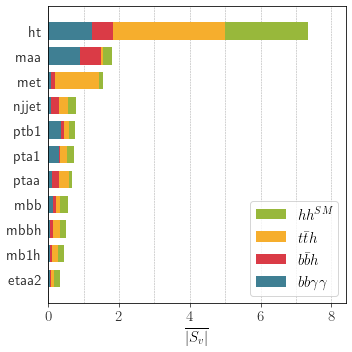

In [105]:
class_names = [r'$bb\gamma\gamma$', r'$b\bar{b}h$', r'$t\bar{t}h$', r'$hh^{SM}$']
filename = 'models/HL-LHC-BDT/hbb-BDT-4class-hhsm-1btag.pickle.dat' ## The pickle model store if necessary.
shap_plot = '../plots/shap-bbxaa-bbh-tth-hhsm.pdf'

classifier, x_test, y_test, shap_values_4, X_shap_4 = runBDT(df_train, filename)
abs_shap(shap_values_4, X_shap_4, shap_plot, names=names, class_names=class_names, cmp=cmp_4)

Accuracy Score for hhsm: 72.07% 
Accuracy Score for tth: 80.64% 
Accuracy Score for bbh: 79.36% 
Accuracy Score for bbxaa: 76.99% 


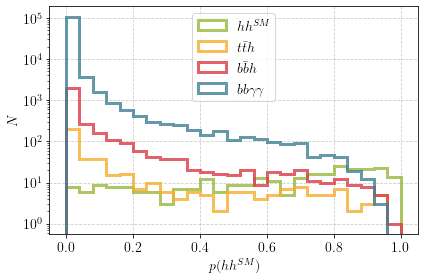

In [106]:
disc = 3
enc=1
hhsm_p = pd.DataFrame(classifier.predict_proba(df_hhsm_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for hhsm: {:4.2f}% '.format(100*metrics.accuracy_score(df_hhsm_test['class'].values, classifier.predict(df_hhsm_test.drop(columns=['class', 'weight']).values))))
hhsm_p['weight'] = df_hhsm_test['weight'].values

tth_p = pd.DataFrame(classifier.predict_proba(df_tth_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for tth: {:4.2f}% '.format(100*metrics.accuracy_score(df_tth_test['class'].values, classifier.predict(df_tth_test.drop(columns=['class', 'weight']).values))))
tth_p['weight'] = df_tth_test['weight'].values

bbh_p = pd.DataFrame(classifier.predict_proba(df_bbh_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbh: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbh_test['class'].values, classifier.predict(df_bbh_test.drop(columns=['class', 'weight']).values))))
bbh_p['weight'] = df_bbh_test['weight'].values

bbxaa_p = pd.DataFrame(classifier.predict_proba(df_bbxaa_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbxaa_test['class'].values, classifier.predict(df_bbxaa_test.drop(columns=['class', 'weight']).values))))
bbxaa_p['weight'] = df_bbxaa_test['weight'].values

hhsm_pred = hhsm_p.sample(n=round(weight_hhsm*1.72*enc), replace=True, random_state=seed).reset_index(drop=True)
tth_pred = tth_p.sample(n=round(weight_tth*1.2*enc), replace=True, random_state=seed).reset_index(drop=True)
bbh_pred = bbh_p.sample(n=round(weight_bbh*enc), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_pred = bbxaa_p.sample(n=round(weight_bbxaa*1.5*enc), replace=True, random_state=seed).reset_index(drop=True)

plt.figure(figsize=(6,4))
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
sns.distplot(hhsm_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(hhsm_pred[0])}, label=r'$hh^{SM}$', color='#98b83b')
sns.distplot(tth_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(tth_pred[0])}, label=r'$t\bar{t}h$', color='#F6AE2D')
sns.distplot(bbh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(bbh_pred[0])}, label=r'$b\bar{b}h$', color='#da3b46')
sns.distplot(bbxaa_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(bbxaa_pred[0])}, label=r'$bb\gamma\gamma$', color='#3f7f93')
plt.legend(loc='upper center', fontsize=14)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel(r'$p(hh^{SM})$', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
plt.yscale('log')
plt.tight_layout()
plt.savefig('../plots/bbxaa-bbh-hhsm-BDT-dist.pdf', dpi=300)

In [107]:
df_array = [df_bbxaa_test, df_bbh_test, df_tth_test, df_hhsm_test]
weight_array = [weight_bbxaa*1.5, weight_bbh, weight_tth*1.2, weight_hhsm*1.72]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True),
                                                                 df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True),
                                                                 df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                 df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_hhsm, sig_hhsm = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_tth, sig_tth = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_bbh, sig_bbh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_hhsm, nevents_tth, nevents_bbh, nevents_bbxaa))

sig: 5.51, hhsm events: 212, tth events: 63, bbh events: 157, bbxaa events: 1051
sig: 11.79, hhsm events: 15, tth events: 324, bbh events: 22, bbxaa events: 393
sig: 14.20, hhsm events: 59, tth events: 13, bbh events: 2363, bbxaa events: 25271
sig: 297.68, hhsm events: 5, tth events: 5, bbh events: 439, bbxaa events: 89062


#### The Confusion Matrix, total events count for each channel and the signal significance

In [108]:
confusion_tot = np.round(np.array([confusion[3], confusion[2], confusion[1], confusion[0]])).astype(int)
event_total = np.array([[np.sum(confusion_tot[i])] for i in range(confusion_tot.shape[0])])
significance = np.append(np.array([np.abs(confusion_tot[i,i])/np.sqrt(np.sum(confusion_tot[:,i])) for i in range(confusion_tot.shape[0])]), 0)
confusion_tab = np.vstack((np.append(confusion_tot, event_total, axis=1), significance))
    
df_conf = pd.DataFrame(confusion_tab, [r'$hh^{SM}$', r'$t\bar{t}h$', r'$b\bar{b}h$', r'$bb\gamma\gamma$', r'$\sigma$'])
df_conf.columns = [r'$hh^{SM}$', r'$t\bar{t}h$', r'$b\bar{b}h$', r'$bb\gamma\gamma$', 'total']
print(df_conf.to_latex(escape=False))

\begin{tabular}{lrrrrr}
\toprule
{} &    $hh^{SM}$ &  $t\bar{t}h$ &   $b\bar{b}h$ &  $bb\gamma\gamma$ &     total \\
\midrule
$hh^{SM}$        &   212.000000 &    15.000000 &     59.000000 &          5.000000 &     291.0 \\
$t\bar{t}h$      &    63.000000 &   324.000000 &     13.000000 &          5.000000 &     405.0 \\
$b\bar{b}h$      &   157.000000 &    22.000000 &   2363.000000 &        439.000000 &    2981.0 \\
$bb\gamma\gamma$ &  1051.000000 &   393.000000 &  25271.000000 &      89062.000000 &  115777.0 \\
$\sigma$         &     5.505101 &    11.799384 &     14.196354 &        297.683141 &       0.0 \\
\bottomrule
\end{tabular}



## The BSM vs. SM analysis

- Add the two datasets
- Run the BDT and make the SHAP plot
- Check the accuracy of the classifier
- make the discriminator plot

In [109]:
df_hhsm['class'] = 0
df_hhsm_test['class'] = 0
df_ku['class'] = 1
df_ku_test['class'] = 1

channels = [df_hhsm, df_ku]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 68.08% 


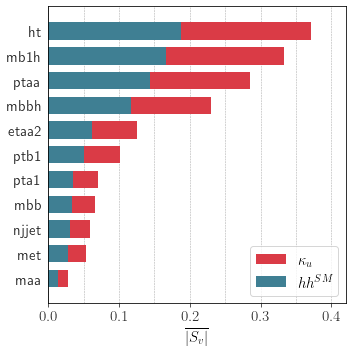

In [110]:
class_names = [r'$hh^{SM}$', r'$\kappa_u$']
filename = 'models/HL-LHC-BDT/hbb-BDT-2class-1btag-kappau.pickle.dat' ## The pickle model store if necessary.
shap_plot = '../plots/shap-kappad.pdf'

classifier, x_test, y_test, shap_values_2, X_shap_2 = runBDT(df_train, filename)
abs_shap(shap_values_2, X_shap_2, shap_plot, names=names, class_names=class_names, cmp=cmp_2)

In [111]:
classifier = pickle.load(open('models/HL-LHC-BDT/hbb-BDT-2class-1btag-kappau.pickle.dat', 'rb')) ## If model is stored
comb_test = pd.concat([df_hhsm_test.iloc[:,:-1].sample(n=20000, random_state=seed, replace=True), df_ku_test.iloc[:,:-1].sample(n=20000, random_state=seed, replace=True)])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 67.71% 


Accuracy Score for kd: 59.12% 
Accuracy Score for hhsm: 76.53% 


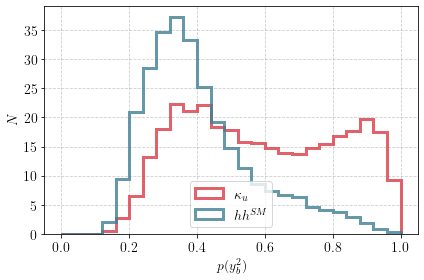

In [112]:
disc = 1
enc=100
ku_p = pd.DataFrame(classifier.predict_proba(df_ku_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for kd: {:4.2f}% '.format(100*metrics.accuracy_score(df_ku_test['class'].values, classifier.predict(df_ku_test.drop(columns=['class', 'weight']).values))))
ku_p['weight'] = df_ku_test['weight'].values

hhsm_p = pd.DataFrame(classifier.predict_proba(df_hhsm_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for hhsm: {:4.2f}% '.format(100*metrics.accuracy_score(df_hhsm_test['class'].values, classifier.predict(df_hhsm_test.drop(columns=['class', 'weight']).values))))
hhsm_p['weight'] = df_hhsm_test['weight'].values

ku_pred = ku_p.sample(n=round(weight_ku*1.28*enc), replace=True, random_state=seed).reset_index(drop=True)
hhsm_pred = hhsm_p.sample(n=round(weight_hhsm*1.72*enc), replace=True, random_state=seed).reset_index(drop=True)

plt.figure(figsize=(6,4))
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
sns.distplot(ku_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(ku_pred[0])}, label=r'$\kappa_u$', color='#da3b46')
sns.distplot(hhsm_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(hhsm_pred[0])}, label=r'$hh^{SM}$', color='#3f7f93')
plt.legend(loc='lower center', fontsize=14)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel(r'$p(y_b^2)$', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
# plt.yscale('log')
plt.tight_layout()
plt.savefig('../plots/hhsm-kd-BDT-dist.pdf', dpi=300)

In [113]:
df_array = [df_hhsm_test, df_ku_test]
weight_array = [weight_hhsm*1.72, weight_ku*1.28/3]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                 df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed,)]).values))

nevents_ku, sig_ku = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_hhsm, sig_hhsm = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_ku, nevents_hhsm))

sig: 5.76, ku events: 67, hhsm events: 70
sig: 13.27, ku events: 44, hhsm events: 212


## The hh NP analysis

- Add the two datasets
- Run the BDT and make the SHAP plot
- Check the accuracy of the classifier
- make the discriminator plot

In [114]:
df_hhsm['class'] = 3
df_hhsm_test['class'] = 3
df_ku['class'] = 4
df_ku_test['class'] = 4

channels = [df_hhsm, df_bbh, df_tth, df_bbxaa, df_ku]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 70.18% 


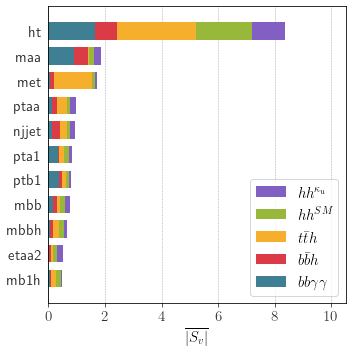

In [115]:
class_names = [r'$bb\gamma\gamma$', r'$b\bar{b}h$', r'$t\bar{t}h$', r'$hh^{SM}$', r'$hh^{\kappa_u}$']
filename = 'models/HL-LHC-BDT/hbb-BDT-4class-hhsm-ku-1btag.pickle.dat' ## The pickle model store if necessary.
shap_plot = '../plots/shap-bbxaa-bbh-tth-hhsm-ku.pdf'

classifier, x_test, y_test, shap_values_5, X_shap_5 = runBDT(df_train, filename)
abs_shap(shap_values_5, X_shap_5, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

Accuracy Score for ku: 38.20% 
Accuracy Score for hhsm: 60.66% 
Accuracy Score for tth: 78.48% 
Accuracy Score for bbh: 77.56% 
Accuracy Score for bbxaa: 77.01% 


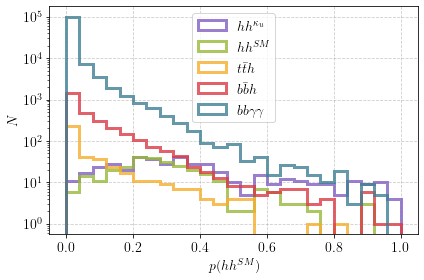

In [116]:
disc = 4
enc=1

ku_p = pd.DataFrame(classifier.predict_proba(df_ku_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for ku: {:4.2f}% '.format(100*metrics.accuracy_score(df_ku_test['class'].values, classifier.predict(df_ku_test.drop(columns=['class', 'weight']).values))))
ku_p['weight'] = df_ku_test['weight'].values

hhsm_p = pd.DataFrame(classifier.predict_proba(df_hhsm_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for hhsm: {:4.2f}% '.format(100*metrics.accuracy_score(df_hhsm_test['class'].values, classifier.predict(df_hhsm_test.drop(columns=['class', 'weight']).values))))
hhsm_p['weight'] = df_hhsm_test['weight'].values

tth_p = pd.DataFrame(classifier.predict_proba(df_tth_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for tth: {:4.2f}% '.format(100*metrics.accuracy_score(df_tth_test['class'].values, classifier.predict(df_tth_test.drop(columns=['class', 'weight']).values))))
tth_p['weight'] = df_tth_test['weight'].values

bbh_p = pd.DataFrame(classifier.predict_proba(df_bbh_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbh: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbh_test['class'].values, classifier.predict(df_bbh_test.drop(columns=['class', 'weight']).values))))
bbh_p['weight'] = df_bbh_test['weight'].values

bbxaa_p = pd.DataFrame(classifier.predict_proba(df_bbxaa_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbxaa_test['class'].values, classifier.predict(df_bbxaa_test.drop(columns=['class', 'weight']).values))))
bbxaa_p['weight'] = df_bbxaa_test['weight'].values

ku_pred = ku_p.sample(n=round(weight_ku*1.72*enc), replace=True, random_state=seed).reset_index(drop=True)
hhsm_pred = hhsm_p.sample(n=round(weight_hhsm*1.72*enc), replace=True, random_state=seed).reset_index(drop=True)
tth_pred = tth_p.sample(n=round(weight_tth*1.2*enc), replace=True, random_state=seed).reset_index(drop=True)
bbh_pred = bbh_p.sample(n=round(weight_bbh*enc), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_pred = bbxaa_p.sample(n=round(weight_bbxaa*1.5*enc), replace=True, random_state=seed).reset_index(drop=True)

plt.figure(figsize=(6,4))
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
sns.distplot(ku_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(ku_pred[0])}, label=r'$hh^{\kappa_u}$', color='#825FC3')
sns.distplot(hhsm_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(hhsm_pred[0])}, label=r'$hh^{SM}$', color='#98b83b')
sns.distplot(tth_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(tth_pred[0])}, label=r'$t\bar{t}h$', color='#F6AE2D')
sns.distplot(bbh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(bbh_pred[0])}, label=r'$b\bar{b}h$', color='#da3b46')
sns.distplot(bbxaa_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(bbxaa_pred[0])}, label=r'$bb\gamma\gamma$', color='#3f7f93')
plt.legend(loc='upper center', fontsize=14)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel(r'$p(hh^{SM})$', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
plt.yscale('log')
plt.tight_layout()
plt.savefig('../plots/bbxaa-bbh-hhsm-BDT-dist.pdf', dpi=300)

In [117]:
df_array = [df_bbxaa_test, df_bbh_test, df_tth_test, df_hhsm_test, df_ku_test]
weight_array = [weight_bbxaa*1.5, weight_bbh, weight_tth*1.2, weight_hhsm*1.72, weight_ku*1.28]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed, replace=True),
                                                                 df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True),
                                                                 df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True),
                                                                 df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                 df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_ku, sig_ku = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_hhsm, sig_hhsm = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_tth, sig_tth = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_bbh, sig_bbh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_ku, nevents_hhsm, nevents_tth, nevents_bbh, nevents_bbxaa))

sig: 4.03, ku events: 123, hhsm events: 41, tth events: 19, bbh events: 91, bbxaa events: 654
sig: 4.88, ku events: 104, hhsm events: 175, tth events: 53, bbh events: 117, bbxaa events: 839
sig: 11.65, ku events: 11, hhsm events: 13, tth events: 313, bbh events: 19, bbxaa events: 367
sig: 14.02, ku events: 80, hhsm events: 52, tth events: 10, bbh events: 2319, bbxaa events: 24898
sig: 297.61, ku events: 9, hhsm events: 5, tth events: 5, bbh events: 439, bbxaa events: 89025
